In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from scipy.optimize import least_squares


In [3]:
# Function to read .cam file and extract translation vector and rotation matrix
def read_cam_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Extract translation vector and rotation matrix from the first line
        first_line = list(map(float, lines[0].split()))
        translation_vector = np.array(first_line[:3])
        rotation_matrix = np.array(first_line[3:]).reshape(3, 3)
    return translation_vector, rotation_matrix

# Get all .cam files in the current folder
cam_files = [f for f in os.listdir('.') if f.endswith('.cam')]

# Separate L and R files
l_files = sorted([f for f in cam_files if '_L' in f])
r_files = sorted([f for f in cam_files if '_R' in f])

# Arrays to store rotation vectors
rotation_vectors_L = []
rotation_vectors_R = []

rotation_matrix_L=[]
rotation_matrix_R=[]
# Process L files
for l_file in l_files:
    _, rotation_matrix = read_cam_file(l_file)
    # Convert rotation matrix to rotation vector
    rotation_matrix_L.append(rotation_matrix)
    rotation_vector = R.from_matrix(rotation_matrix).as_rotvec()
    rotation_vectors_L.append(rotation_vector)

# Process R files
for r_file in r_files:
    _, rotation_matrix = read_cam_file(r_file)
    rotation_matrix_R.append(rotation_matrix)
    # Convert rotation matrix to rotation vector
    rotation_vector = R.from_matrix(rotation_matrix).as_rotvec()
    rotation_vectors_R.append(rotation_vector)

# Convert to numpy arrays
rotation_vectors_L = np.array(rotation_vectors_L)
rotation_vectors_R = np.array(rotation_vectors_R)

rotation_matrix_L=np.array(rotation_matrix_L)
rotation_matrix_R=np.array(rotation_matrix_R)

In [4]:
def residuals(params, R):
    N = R.shape[0]  # Number of cameras
    x2, y2, z2 = params[:3]  # Tilt vector
    phi, theta = params[3:5]  # Unit vector parameters
    Rot = params[5:]  # Rotation angles for each camera
    
    e1 = np.sin(phi) * np.cos(theta)
    e2 = np.sin(phi) * np.sin(theta)
    e3 = np.cos(phi)
    
    residuals = []
    for i in range(N):
        R_i = R[i]
        pred = np.array([x2, y2, z2]) + Rot[i] * np.array([e1, e2, e3])
        residuals.append(R_i - pred)
    return np.array(residuals).flatten()

def phi_to_e(phi,theta):
    e1 = np.sin(phi) * np.cos(theta)
    e2 = np.sin(phi) * np.sin(theta)
    e3 = np.cos(phi)
    return(np.array([e1,e2,e3]))

In [5]:
# Initial guesses
x2_init, y2_init, z2_init = 0.0, 0.0, 0.0
phi_init, theta_init = np.pi/4, np.pi/4
Rot_init = np.ones(rotation_vectors_R.shape[0])

params_init = np.hstack(([x2_init, y2_init, z2_init, phi_init, theta_init], Rot_init))

In [6]:
result_R = least_squares(residuals, params_init, args=(rotation_vectors_R,), method='trf',bounds=(-2 * np.pi, 2 * np.pi))
result_L = least_squares(residuals, params_init, args=(rotation_vectors_L,), method='trf',bounds=(-2 * np.pi, 2 * np.pi))

In [7]:
x2_R, y2_R, z2_R = result_R.x[:3]
phi_R, theta_R = result_R.x[3:5]
Rot_R = result_R.x[5:]
e_R = phi_to_e(phi_R,theta_R)



x2_L, y2_L, z2_L = result_L.x[:3]
phi_L, theta_L= result_L.x[3:5]
Rot_L= result_L.x[5:]
e_L = phi_to_e(phi_L,theta_L)

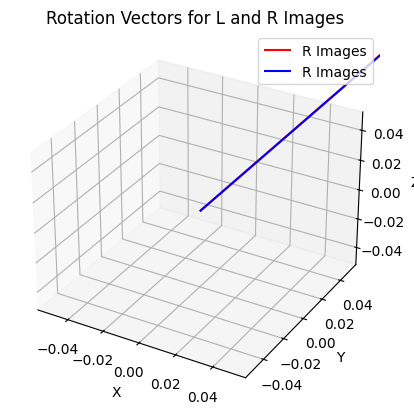

In [8]:
# Plot the rotation vectors in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot L vectors
# ax.quiver(
#     np.zeros(len(rotation_vectors_R)), np.zeros(len(rotation_vectors_R)), np.zeros(len(rotation_vectors_R)),
#     rotation_vectors_R[:, 0], rotation_vectors_R[:, 1], rotation_vectors_R[:, 2],
#     color='blue', label='L Images'
# )

# Plot R vectors
ax.quiver(
    0, 0, 0,e_R[0], e_R[1], e_R[2],color='red', label='R Images'
)


ax.quiver(
    0, 0, 0,e_L[0], e_L[1], e_L[2],color='blue', label='R Images'
)
# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax.set_title('Rotation Vectors for L and R Images')

# Show the plot
plt.show()

In [9]:
e_R-e_L

array([0.01029236, 0.00017736, 0.01620836])

In [10]:
np.linalg.norm(e_R-e_L)*180/np.pi

1.1001311895265034

In [11]:
x2_R, y2_R, z2_R

(0.0005188810931832374, -1.3340253246947995, -0.0005903937878734088)

In [12]:
x2_L, y2_L, z2_L

(0.03437013214579447, -1.3255460865309256, -0.00509868451493731)

In [13]:
1.3340253246947995*180/3.14

76.47278931371461

In [16]:
rot,_ = R.align_vectors([x2_R, y2_R, z2_R],[x2_L, y2_L, z2_L])

In [17]:
rot.as_rotvector()

AttributeError: 'scipy.spatial.transform._rotation.Rotation' object has no attribute 'as_rotvector'